In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score


## Exploring The Server Machine Dataset

SMD (Server Machine Dataset) is a new 5-week-long dataset. We collected it from a large Internet company. This dataset contains 3 groups of entities. Each of them is named by *machine-group_index-index*.

SMD is made up by data from 28 different machines, and the 28 subsets should be trained and tested separately. For each of these subsets, we divide it into two parts of equal length for training and testing. We provide labels for whether a point is an anomaly and the dimensions contribute to every anomaly.

Thus SMD is made up by the following parts:

- train: The former half part of the dataset.
- test: The latter half part of the dataset.
- test_label: The label of the test set. It denotes whether a point is an anomaly.
- interpretation_label: The lists of dimensions contribute to each anomaly.

In [47]:
dataset = 'SMD'
data_path = "../ServerMachineDataset/processed"
x_dim = 38

file = 1, 2

In [48]:
f = open(f'{data_path}/machine-{file[0]}-{file[1]}_train.pkl', "rb")
data = pickle.load(f).reshape((-1, x_dim))
f.close()
df = pd.DataFrame(data)
df.head()

0         1         2         3         4         5         6    7   \
0  0.16  0.058339  0.090032  0.114586  0.122642  0.899967  0.262767  0.0   
1  0.11  0.048404  0.083601  0.111170  0.122642  0.859680  0.262093  0.0   
2  0.11  0.044599  0.076923  0.107227  0.122642  0.860669  0.261962  0.0   
3  0.12  0.053266  0.075686  0.105125  0.122642  0.781639  0.184000  0.0   
4  0.11  0.044599  0.070492  0.101708  0.122642  0.702331  0.106054  0.0   

         8         9   ...   28   29        30   31    32        33   34   35  \
0  0.000746  0.012437  ...  0.0  0.0  0.045032  0.0  0.25  0.090278  0.0  0.0   
1  0.000187  0.000315  ...  0.0  0.0  0.028284  0.0  0.25  0.076389  0.0  0.0   
2  0.000187  0.000005  ...  0.0  0.0  0.034611  0.0  0.25  0.069444  0.0  0.0   
3  0.000187  0.000438  ...  0.0  0.0  0.071083  0.0  0.25  0.069444  0.0  0.0   
4  0.000840  0.000000  ...  0.0  0.0  0.025307  0.0  0.25  0.069444  0.0  0.0   

    36   37  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  

[5 rows x 38 columns]

<Figure size 432x288 with 0 Axes>

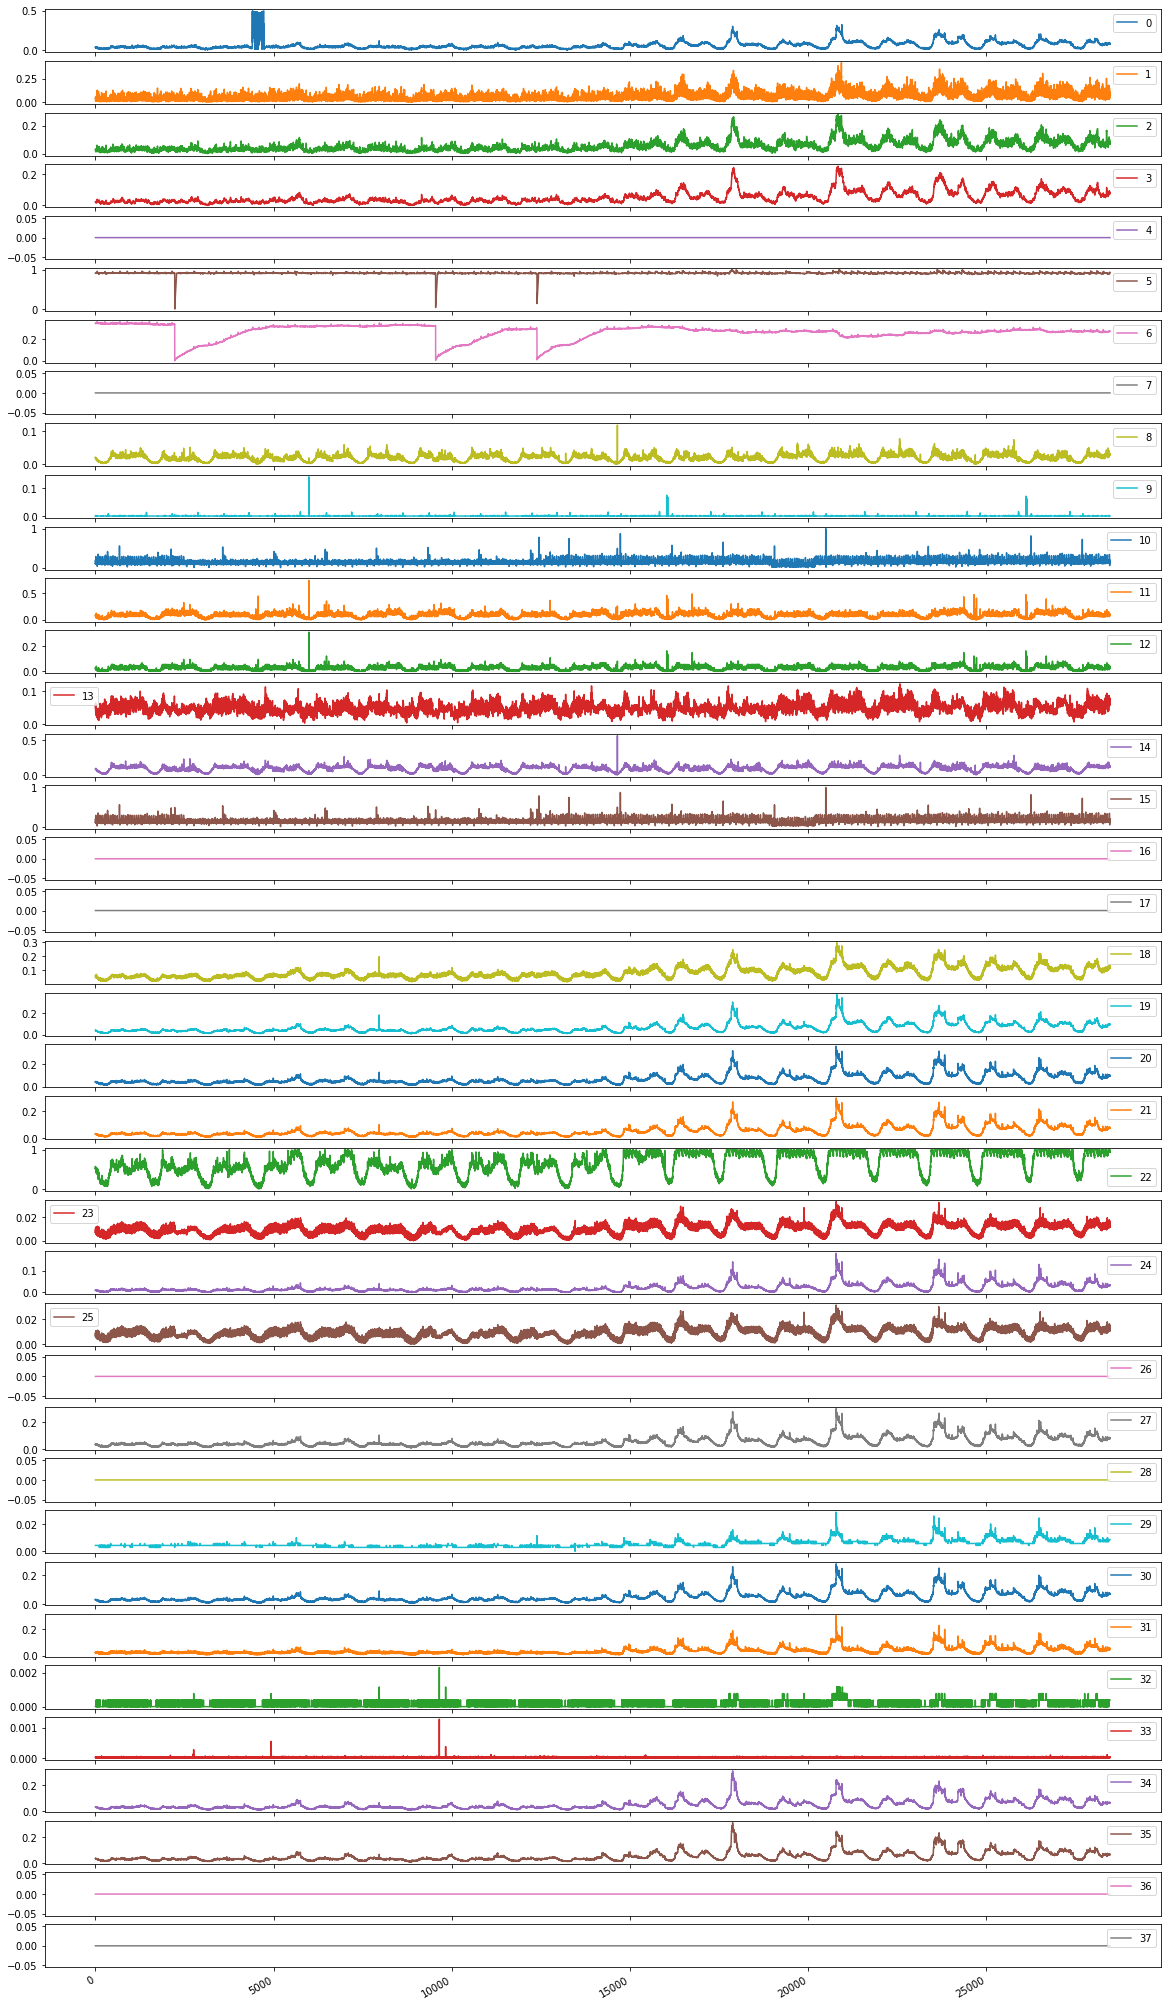

In [4]:
plt.tight_layout()
df.plot(subplots=True, figsize=(20,40))
plt.show();

In [50]:
f = open(f'{data_path}/machine-{file[0]}-{file[1]}_test.pkl', "rb")
data = pickle.load(f).reshape((-1, x_dim))
f.close()
df_test = pd.DataFrame(data)

f = open(f'{data_path}/machine-{file[0]}-{file[1]}_test_label.pkl', "rb")
test_labels = pickle.load(f)
f.close()
df_test['Anomaly'] = test_labels

<Figure size 432x288 with 0 Axes>

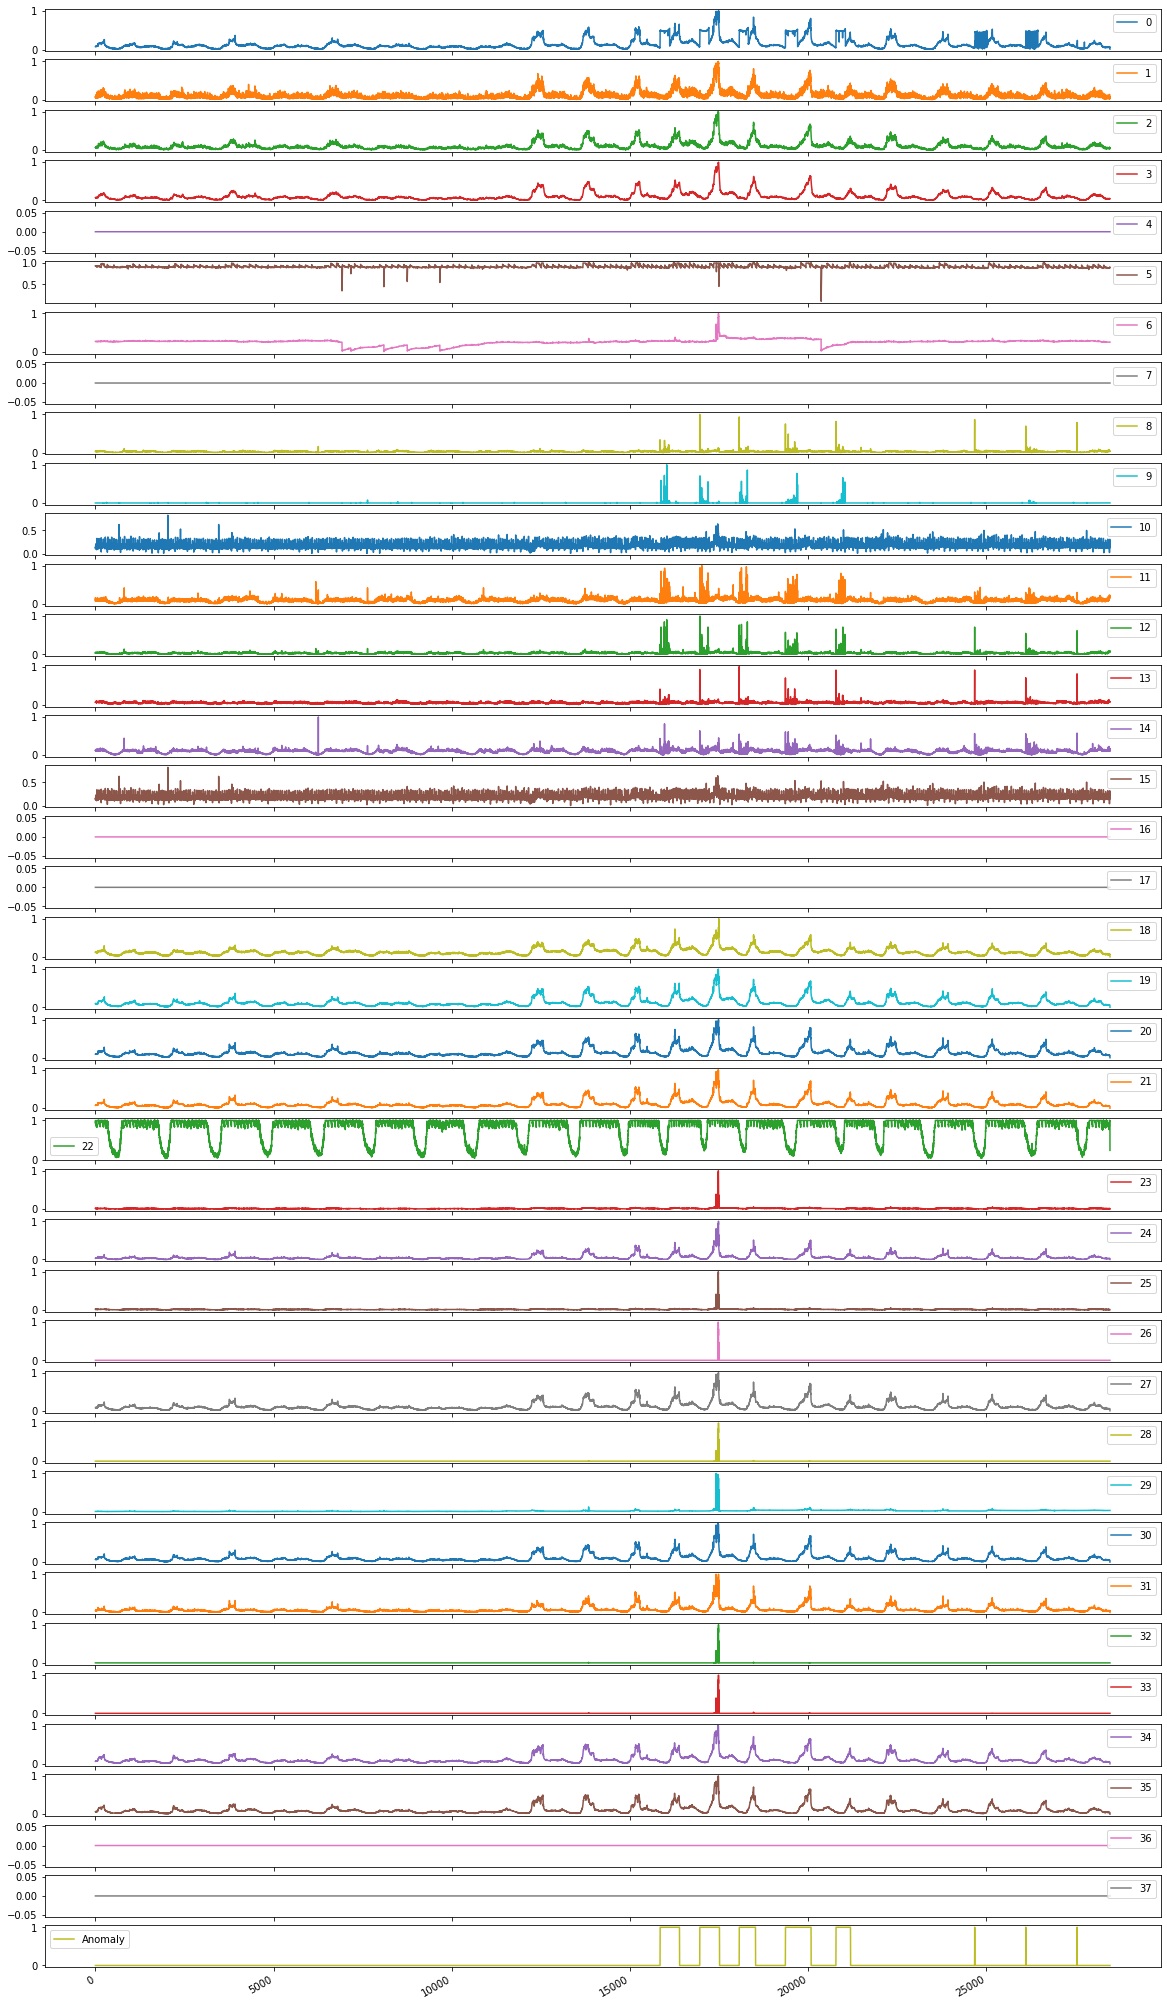

In [7]:
plt.tight_layout()
df_test.plot(subplots=True, figsize=(20,40))
plt.show();

In [8]:
df.shape[0] + df_test.shape[0]

56958

In [52]:
df_comb = pd.concat([df, df_test], ignore_index=True)
df_comb.shape

(47388, 39)

<Figure size 432x288 with 0 Axes>

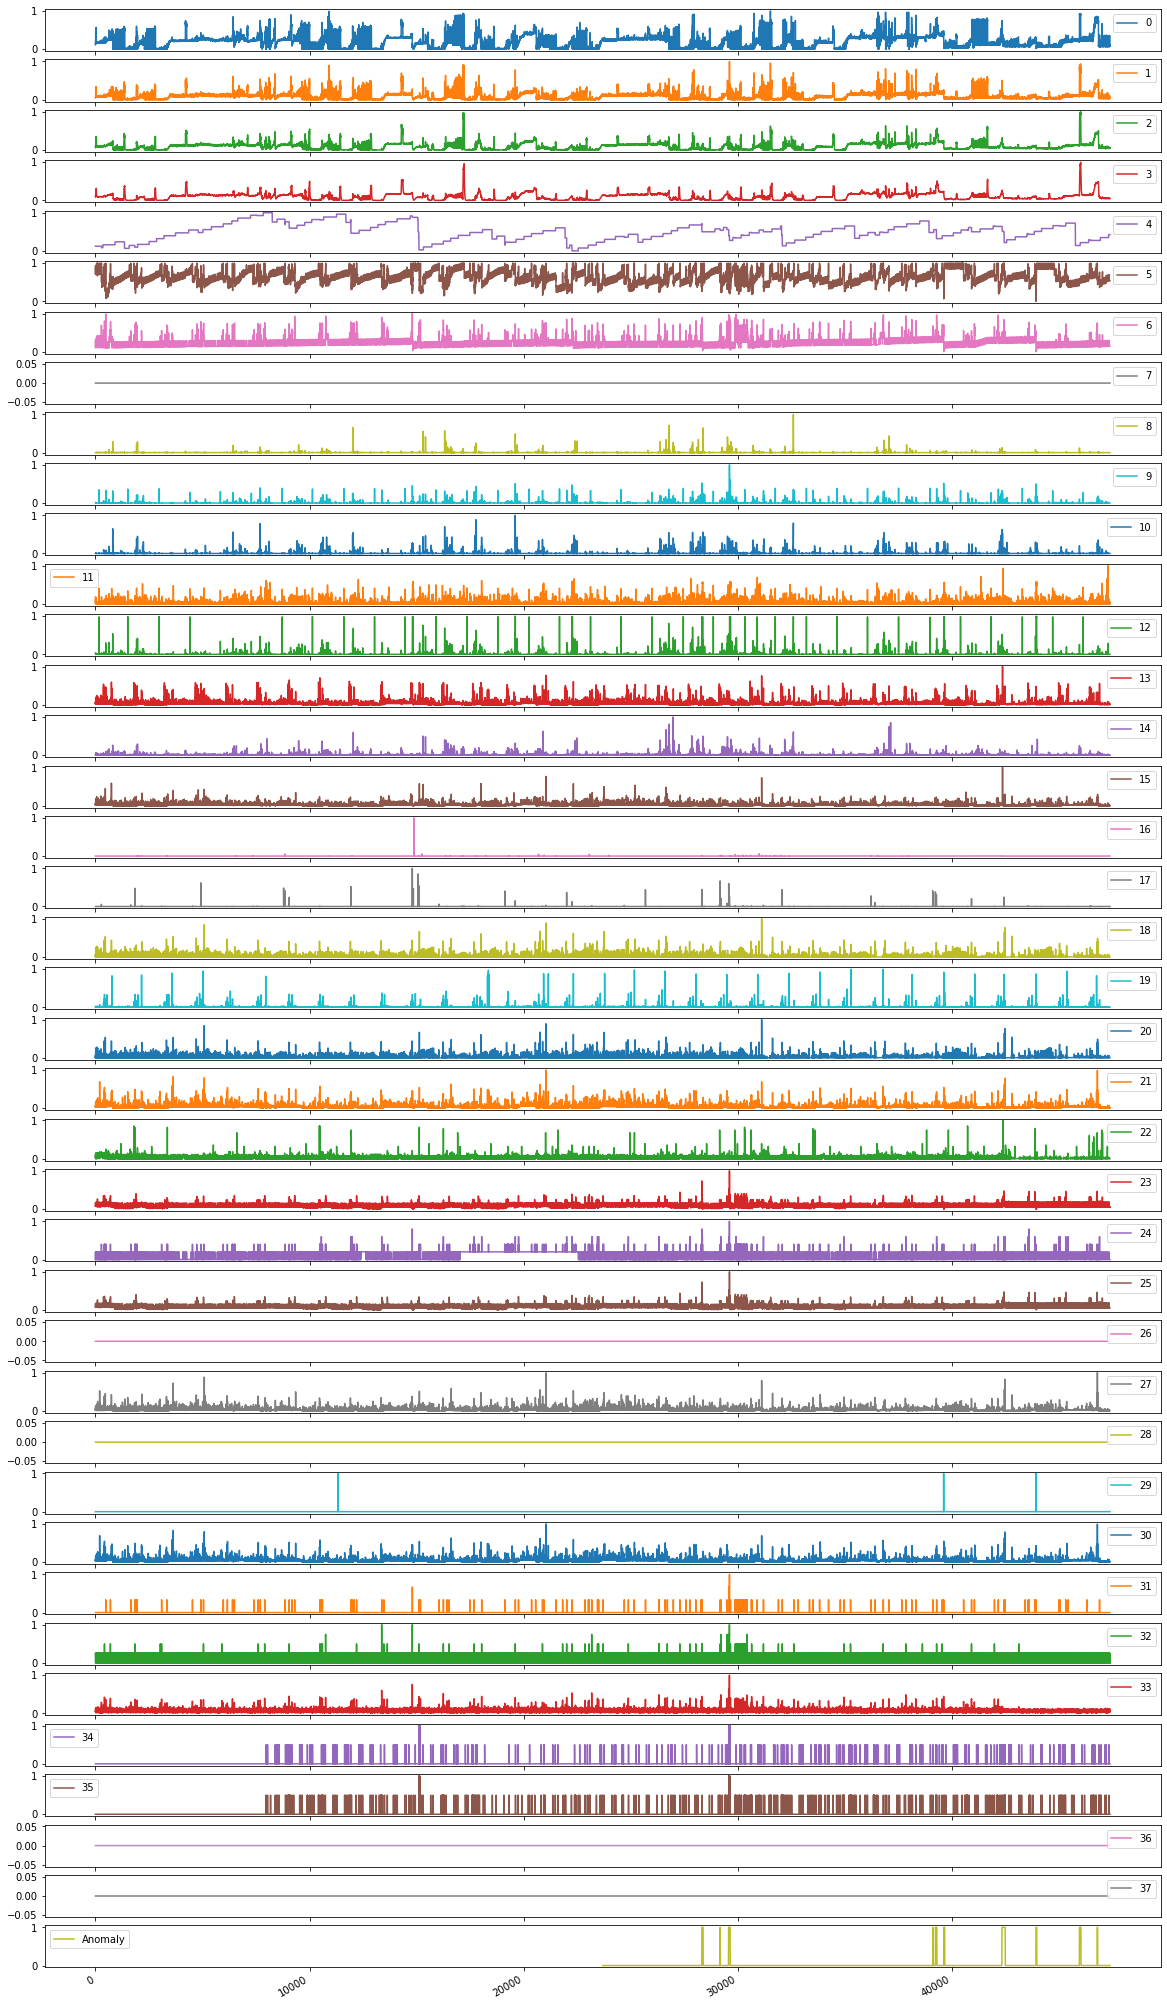

In [53]:
plt.tight_layout()
df_comb.plot(subplots=True, figsize=(20,40))
plt.show();

## Exploring Spectral Residual for removing outliers in training data 

In [10]:
from alibi_detect.od import SpectralResidual
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_ts
from scipy import interpolate

od = SpectralResidual(
    threshold=None,
    window_amp=500,
    window_local=500,
    n_est_points=10,
    n_grad_points=5
)

No threshold level set. Need to infer threshold using `infer_threshold`.


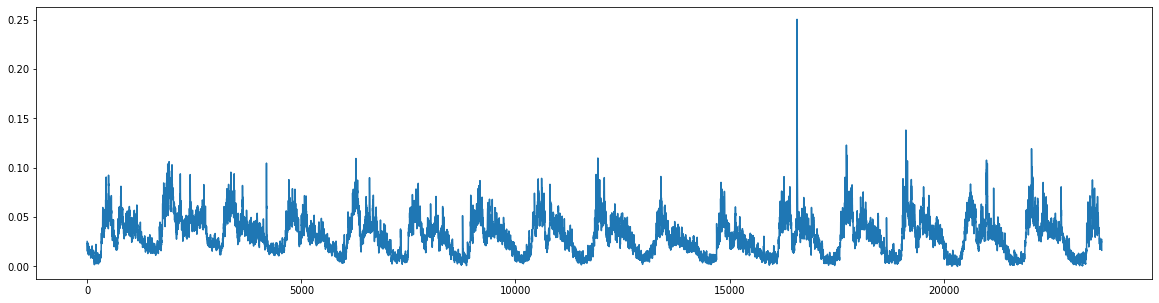

In [11]:
x = df.iloc[:,2].values
plt.figure(figsize=(20, 5))
plt.plot(x)

In [12]:
od.infer_threshold(x, threshold_perc=99.9)
od.threshold

4.166644035446716

In [13]:
preds = od.predict(
    x,
    #t=t,  # array with timesteps, assumes dt=1 between observations if omitted
    return_instance_score=True
)

In [14]:
preds

{'data': {'instance_score': array([ 6.96504892,  1.79670882,  3.63287959, ..., -0.42278145,
          0.37681006, -0.77091269]),
  'feature_score': None,
  'is_outlier': array([1, 0, 0, ..., 0, 0, 0])},
 'meta': {'name': 'SpectralResidual',
  'detector_type': 'online',
  'data_type': 'time-series'}}

In [15]:
a_scores = preds['data']['instance_score']
is_a = preds['data']['is_outlier']

print(is_a.shape)
print(x.shape)

(23693,)
(23693,)


In [16]:
x_interp = x.copy()
x_interp[np.where(is_a == 1)] = np.NaN
x_interp = pd.Series(x_interp)
print(pd.isna(x_interp).sum())
x_interp = x_interp.interpolate(method='pad')
print(pd.isna(x_interp).sum())

24
1


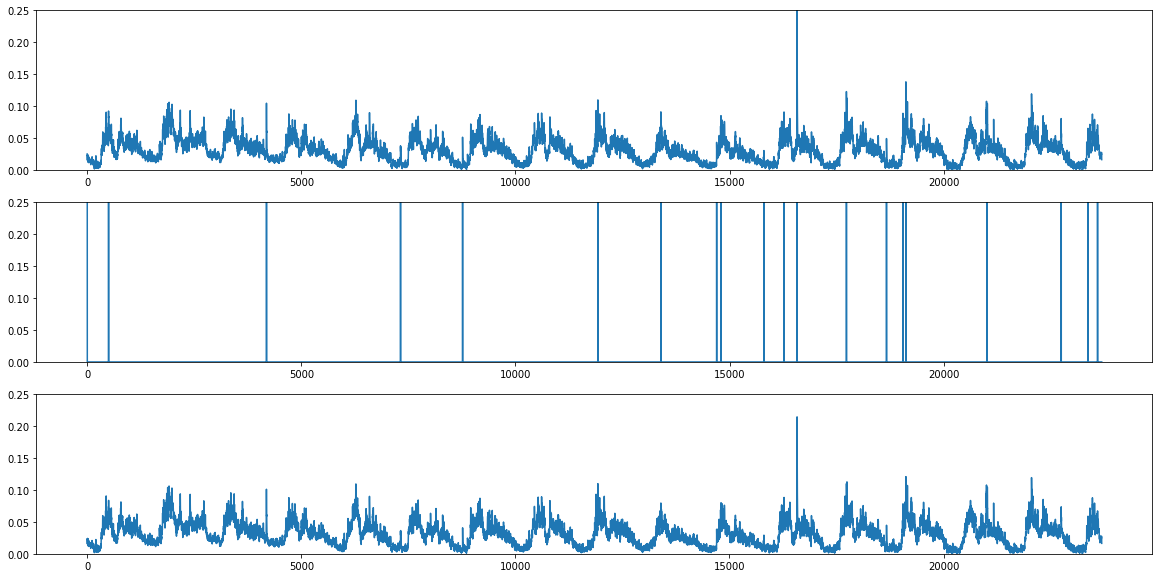

In [17]:

fig, axs = plt.subplots(3, figsize=(20,10))
axs[0].set_ylim([0, max(x)])
axs[1].set_ylim([0, max(x)])
axs[2].set_ylim([0, max(x)])

axs[0].plot(x)
axs[1].plot(is_a)
axs[2].plot(x_interp)


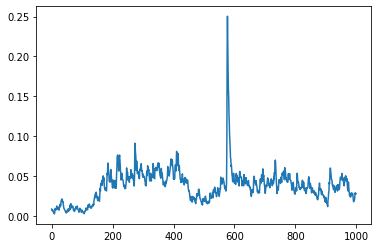

In [18]:
plt.plot(x[16000:17000])

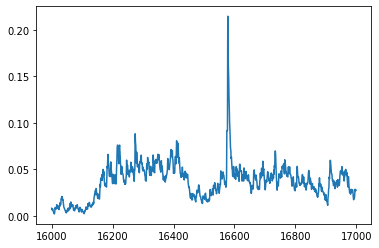

In [19]:
plt.plot(x_interp[16000:17000])

## Results (forecastings, reconstructions, anomaly scores) for trained model on train and test data

In [290]:
output = pd.read_pickle('../output/smd/1-1/test_out.pkl')

In [291]:
output.head()

Pred_0   Recon_0    True_0  A_Score_0    Pred_1   Recon_1    True_1  \
0  0.141692  0.149757  0.150538   0.009627  0.120846  0.132502  0.153602   
1  0.147164  0.156881  0.161290   0.018535  0.104490  0.137837  0.159958   
2  0.154090  0.156164  0.161290   0.012326  0.113643  0.141576  0.150424   
3  0.149776  0.154873  0.161290   0.017931  0.120297  0.143679  0.115466   
4  0.149155  0.158169  0.161290   0.015257  0.108804  0.140832  0.137712   

   A_Score_1    Pred_2   Recon_2  ...       Pred_36  Recon_36  True_36  \
0   0.053855  0.131449  0.128453  ... -3.173230e-04 -0.001833      0.0   
1   0.077589  0.128281  0.139390  ... -1.496067e-04  0.000232      0.0   
2   0.045630  0.129484  0.140963  ... -4.895963e-06 -0.001639      0.0   
3   0.033044  0.131655  0.144020  ... -1.666909e-04  0.000576      0.0   
4   0.032027  0.120996  0.141898  ...  8.707866e-07 -0.000880      0.0   

   A_Score_36   Pred_37  Recon_37  True_37  A_Score_37  Pred_Anomaly  \
0    0.002151 -0.000524  0.000354      0.0    0.000879            -1   
1    0.000382 -0.000445  0.001093      0.0    0.001539            -1   
2    0.001644 -0.000294  0.000740      0.0    0.001034            -1   
3    0.000742 -0.000113 -0.000074      0.0    0.000187            -1   
4    0.000881 -0.000218  0.000559      0.0    0.000777            -1   

   True_Anomaly  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  

[5 rows x 154 columns]

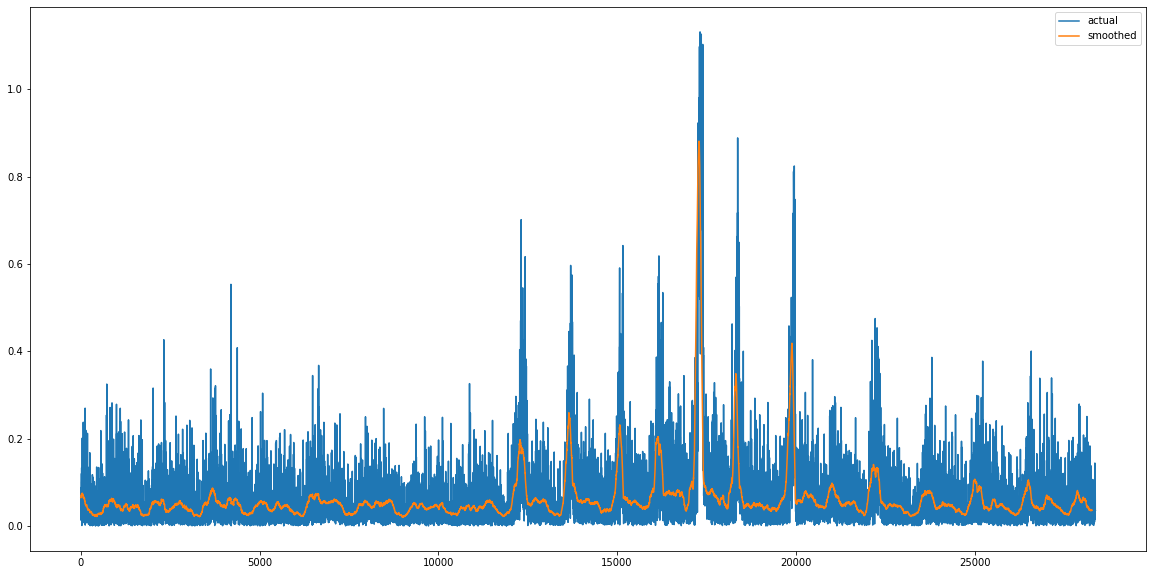

In [233]:
xi = output['A_Score_1'].values
N = 100
si = np.convolve(xi, np.ones(N)/N, mode='valid')

plt.figure(figsize=(20, 10))
plt.plot(xi, label='actual')
plt.plot(si, label='smoothed')

plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

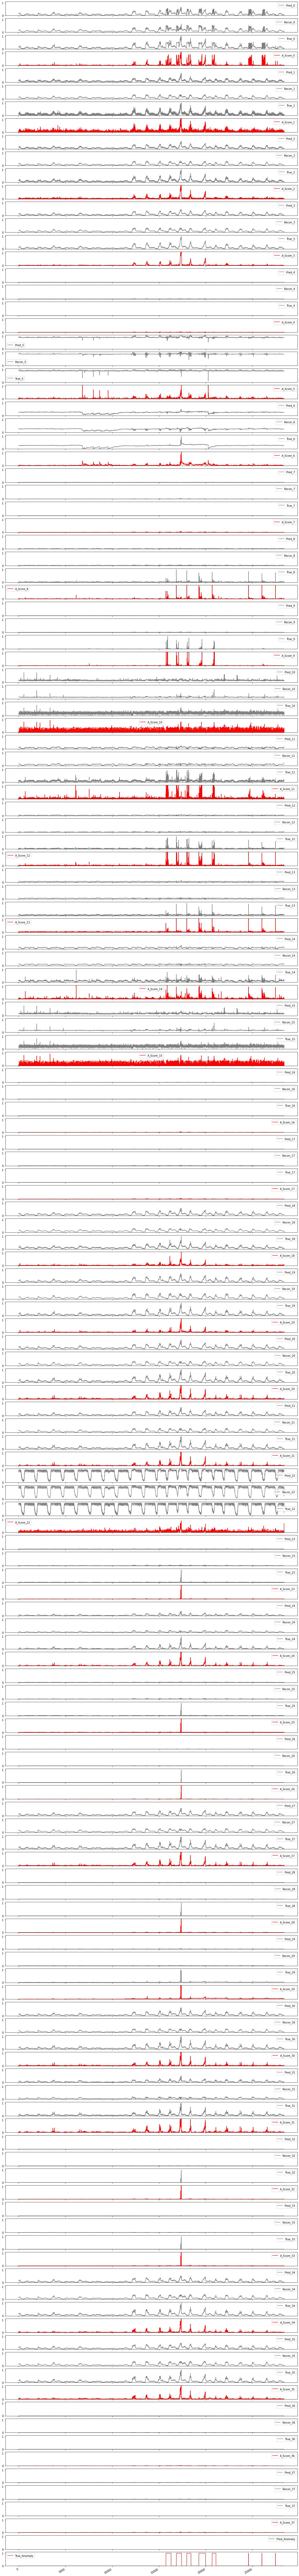

In [217]:
plt.tight_layout()
colors = ['gray', 'gray', 'gray', 'r']*(output.shape[1] // 4)
output.plot(subplots=True, figsize=(20,200), ylim=(0,1.1), style=colors)
plt.show();

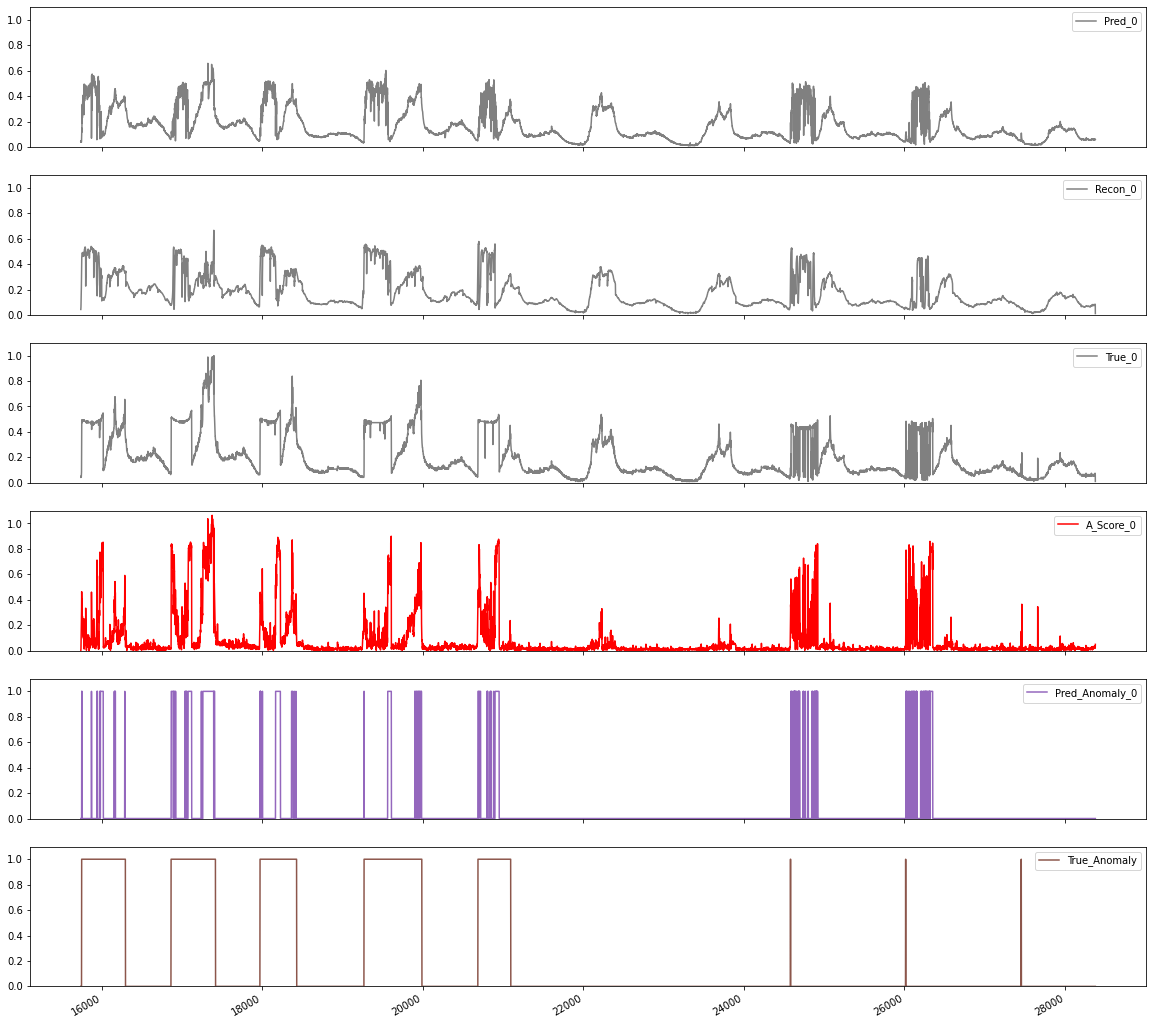

In [293]:
i = 0

# Calculate threshold loss = mean + 3std
rses = output.loc[:, f'A_Score_{i}']
thresh = np.mean(rses) + 3*np.std(rses)

output[f'Pred_Anomaly_{i}'] = (rses > thresh).astype(int)

start, end = 15849, 16368
df = output.loc[start-110:, [f'Pred_{i}', f'Recon_{i}', f'True_{i}', f'A_Score_{i}', f'Pred_Anomaly_{i}','True_Anomaly']]
df.plot(subplots=True, figsize=(20, 20), ylim=(0,1.1), style=['gray', 'gray', 'gray', 'r'])
plt.show()

In [294]:
print(precision_score(output['True_Anomaly'], output[f'Pred_Anomaly_{i}']))
print(recall_score(output['True_Anomaly'], output[f'Pred_Anomaly_{i}']))
print(f1_score(output['True_Anomaly'], output[f'Pred_Anomaly_{i}']))

0.7886944818304172
0.21752041573867856
0.3409950538260111


<Figure size 1440x720 with 0 Axes>

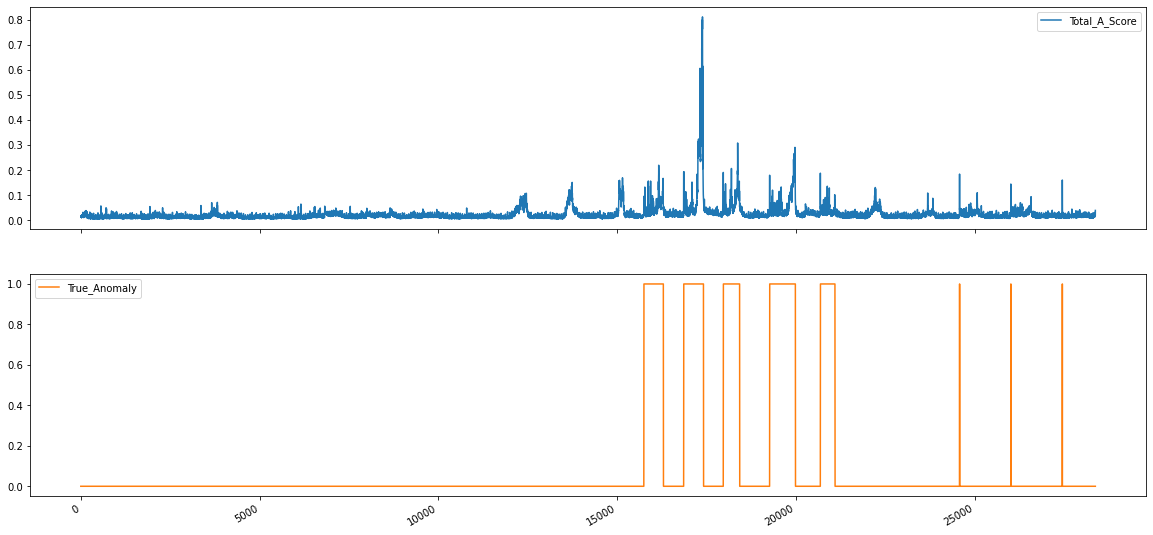

In [295]:
rses = output.loc[:, [f'A_Score_{i}' for i in range(x_dim)]]
output['Total_A_Score'] = rses.mean(1)

plt.figure(figsize=(20, 10))
start, end = 15849, 16368
df = output.loc[:, ['Total_A_Score', 'True_Anomaly']]
df.plot(subplots=True, figsize=(20, 10))
plt.show()


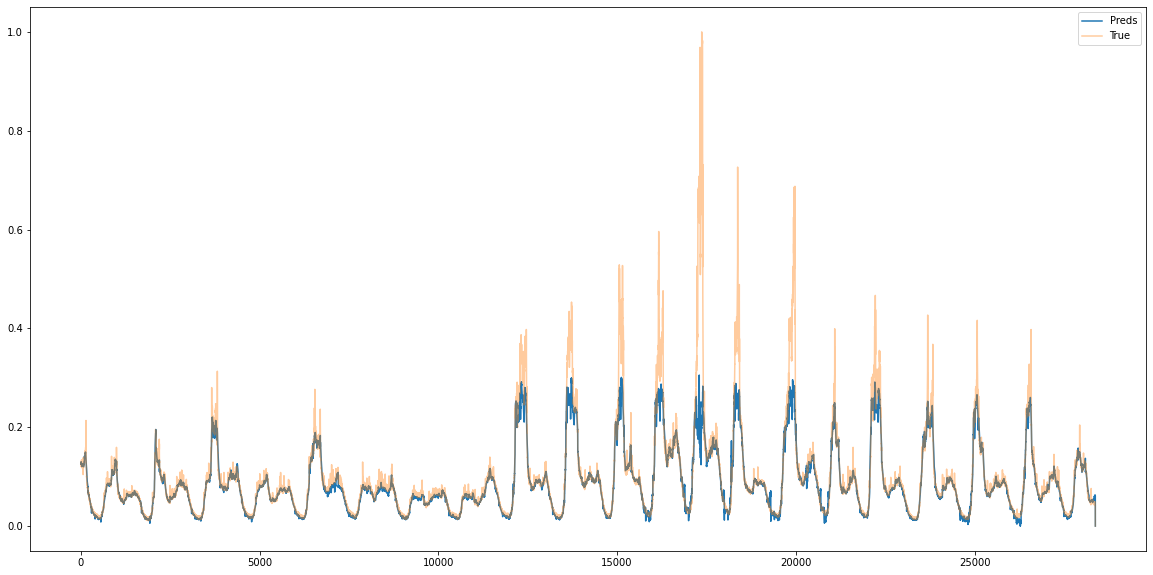

In [296]:
i = 30
# Plot
plt.figure(figsize=(20, 10))
recon = output.loc[:, [f'Recon_{i}']]
true_y = output.loc[:, [f'True_{i}']]

plt.plot(recon.values, label='Preds')
plt.plot(true_y.values, label='True', alpha=0.4)

plt.legend()

In [297]:
# Compute anomaly for every feature
for i in range(38):
    rses = output.loc[:, f'A_Score_{i}']
    thresh = np.mean(rses) + 15*np.std(rses)
    
    output[f'Pred_Anomaly_{i}'] = (rses > thresh).astype(int)

anomaly_preds = output.loc[:, [f'Pred_Anomaly_{i}' for i in range(38)]]
print(anomaly_preds.shape)

output['Pred_Anomaly_Global'] = (np.sum(anomaly_preds, 1) > 1).astype(int)
output.head()

(28379, 38)


Pred_0   Recon_0    True_0  A_Score_0    Pred_1   Recon_1    True_1  \
0  0.141692  0.149757  0.150538   0.009627  0.120846  0.132502  0.153602   
1  0.147164  0.156881  0.161290   0.018535  0.104490  0.137837  0.159958   
2  0.154090  0.156164  0.161290   0.012326  0.113643  0.141576  0.150424   
3  0.149776  0.154873  0.161290   0.017931  0.120297  0.143679  0.115466   
4  0.149155  0.158169  0.161290   0.015257  0.108804  0.140832  0.137712   

   A_Score_1    Pred_2   Recon_2  ...  Pred_Anomaly_29  Pred_Anomaly_30  \
0   0.053855  0.131449  0.128453  ...                0                0   
1   0.077589  0.128281  0.139390  ...                0                0   
2   0.045630  0.129484  0.140963  ...                0                0   
3   0.033044  0.131655  0.144020  ...                0                0   
4   0.032027  0.120996  0.141898  ...                0                0   

   Pred_Anomaly_31  Pred_Anomaly_32  Pred_Anomaly_33  Pred_Anomaly_34  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Pred_Anomaly_35  Pred_Anomaly_36  Pred_Anomaly_37  Pred_Anomaly_Global  
0                0                0                0                    0  
1                0                0                0                    0  
2                0                0                0                    0  
3                0                0                0                    0  
4                0                0                0                    0  

[5 rows x 194 columns]

In [298]:
print(precision_score(output['True_Anomaly'], output['Pred_Anomaly_Global']))
print(recall_score(output['True_Anomaly'], output['Pred_Anomaly_Global']))
print(f1_score(output['True_Anomaly'], output['Pred_Anomaly_Global']))

0.890625
0.021158129175946547
0.04133430021754895


 ## Evaluation strategy
In [MTAD-GAT paper](https://arxiv.org/pdf/2009.02040.pdf) they follow the evaluation strategy that has become a common evaluation strategy for anomaly detection, for instance [[1] Time-Series Anomaly Detection Service at Microsof](https://arxiv.org/pdf/1906.03821.pdf) and [[2] Unsupervised Anomaly
Detection via Variational Auto-Encoder for Seasonal KPIs in Web Applications](https://arxiv.org/pdf/1802.03903.pdf)

**Strategy**: If any point in an anomaly segment can be detected by the algorithm, and the delay of this point is no more than *k* from the start point of the anomaly segment, we say this segment is detected correctly. Thus, all points in this segment are treated as correct, and the points outside the anomaly segments are treated as normal.

*k* will vary depending on the granularity of the data, and should follow the requirements of real applications. [1] set k = 7 for minutely time-series, k = 3 for hourly time-series and k = 1 for daily time-series. Some people instead set k so that as long as any point within the anomaly segment is classified as an anomaly, the whole segment will be labeled correctly, and instead also outputs the delay.

In [357]:
# Code from Time-Series Anomaly Detection Service at Microsof: https://arxiv.org/pdf/1906.03821.pdf


# Consider delay threshold and missing segments
def get_range_proba(predict, label, delay=7, advance=0):
    # Added advance in case model predicts anomaly 'in advance' within a small window
    # Advance should be 0 or small
    
    splits = np.where(label[1:] != label[:-1])[0] + 1
    print(splits)
    is_anomaly = label[0] == 1
    new_predict = np.array(predict)
    pos = 0

    for sp in splits:
        if is_anomaly:
            if 1 in predict[(pos-advance):min(pos + delay + 1, sp)]:
                new_predict[pos: sp] = 1
            else:
                new_predict[pos: sp] = 0
        is_anomaly = not is_anomaly
        pos = sp
    sp = len(label)

    if is_anomaly:  # anomaly in the end
        if 1 in predict[(pos-advance): min(pos + delay + 1, sp)]:
            new_predict[pos: sp] = 1
        else:
            new_predict[pos: sp] = 0

    return new_predict

[15749 16295 16863 17417 17971 18428 19267 19988 20686 21095 24579 24582
 26014 26016 27454 27456]


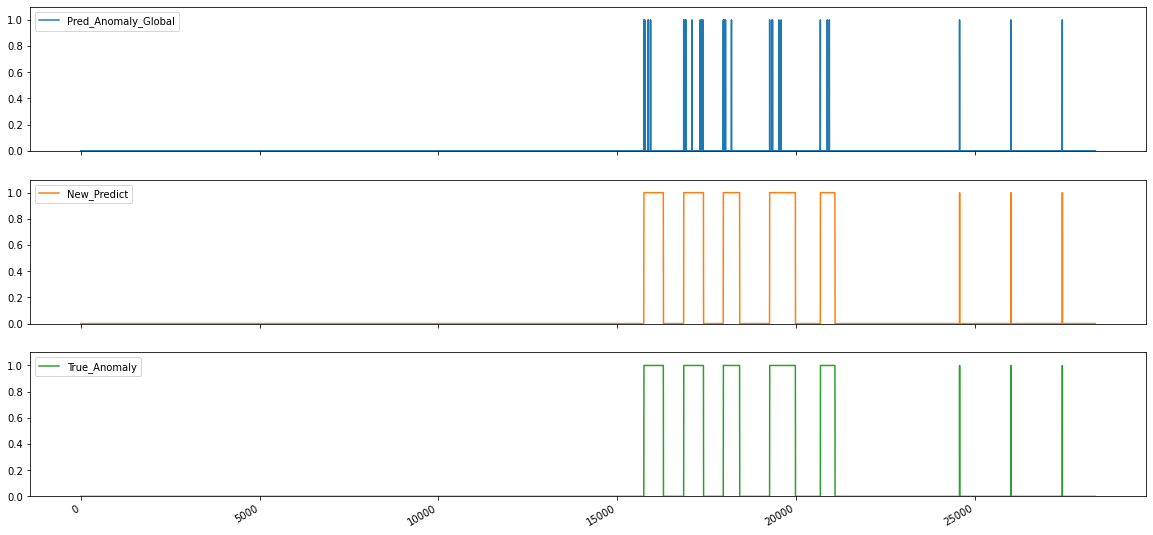

In [358]:
predict = output.loc[:, 'Pred_Anomaly_Global'].values
label = output.loc[:, 'True_Anomaly'].values

output['New_Predict'] = get_range_proba(predict, label, delay=7, advance=1)
output.loc[:, ['Pred_Anomaly_Global', 'New_Predict', 'True_Anomaly']].plot(subplots=True, figsize=(20, 10), ylim=(0,1.1))
plt.show()

In [359]:
print('precision: ', precision_score(output['True_Anomaly'], output['New_Predict']))
print('recall:    ', recall_score(output['True_Anomaly'], output['New_Predict']))
print('f1 score:  ', f1_score(output['True_Anomaly'], output['New_Predict']))

precision:  0.9974083672713809
recall:     1.0
f1 score:   0.9987025023169601


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

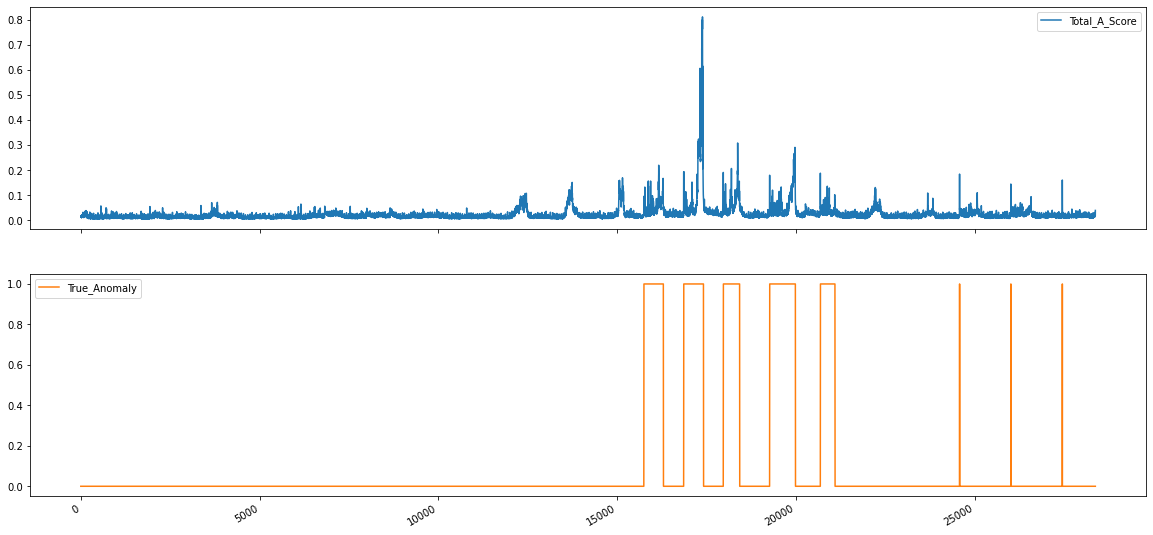

In [255]:
output.loc[:, [f'Total_A_Score', 'True_Anomaly']].plot(subplots=True, figsize=(20, 10))

In [304]:
from pyextremes import EVA, __version__
import pyextremes
print("pyextremes", __version__)

pyextremes 2.2.1


In [305]:
df = output.copy()
mock_datetimes = pd.date_range('2000-01-01', periods=df.shape[0], freq='T')
df['datetime'] = mock_datetimes
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.tail()

Pred_0   Recon_0    True_0  A_Score_0    Pred_1  \
datetime                                                                 
2000-01-20 16:54:00  0.056733  0.083407  0.075269   0.026674  0.054323   
2000-01-20 16:55:00  0.059703  0.083414  0.064516   0.023711  0.065722   
2000-01-20 16:56:00  0.061180  0.083060  0.064516   0.021881  0.058060   
2000-01-20 16:57:00  0.061638  0.083730  0.064516   0.022092  0.076831   
2000-01-20 16:58:00  0.060337  0.010753  0.010753   0.049584  0.065541   

                      Recon_1    True_1  A_Score_1    Pred_2   Recon_2  ...  \
datetime                                                                ...   
2000-01-20 16:54:00  0.070793  0.051907   0.021302  0.046313  0.062728  ...   
2000-01-20 16:55:00  0.070944  0.025424   0.085819  0.051338  0.062692  ...   
2000-01-20 16:56:00  0.071092  0.080508   0.031865  0.046773  0.062805  ...   
2000-01-20 16:57:00  0.071380  0.056144   0.035923  0.060489  0.062732  ...   
2000-01-20 16:58:00  0.029661  0.029661   0.035880  0.057973  0.041249  ...   

                     Pred_Anomaly_30  Pred_Anomaly_31  Pred_Anomaly_32  \
datetime                                                                 
2000-01-20 16:54:00                0                0                0   
2000-01-20 16:55:00                0                0                0   
2000-01-20 16:56:00                0                0                0   
2000-01-20 16:57:00                0                0                0   
2000-01-20 16:58:00                0                0                0   

                     Pred_Anomaly_33  Pred_Anomaly_34  Pred_Anomaly_35  \
datetime                                                                 
2000-01-20 16:54:00                0                0                0   
2000-01-20 16:55:00                0                0                0   
2000-01-20 16:56:00                0                0                0   
2000-01-20 16:57:00                0                0                0   
2000-01-20 16:58:00                0                0                0   

                     Pred_Anomaly_36  Pred_Anomaly_37  Pred_Anomaly_Global  \
datetime                                                                     
2000-01-20 16:54:00                0                0                    0   
2000-01-20 16:55:00                0                0                    0   
2000-01-20 16:56:00                0                0                    0   
2000-01-20 16:57:00                0                0                    0   
2000-01-20 16:58:00                0                0                    0   

                     New_Predict  
datetime                          
2000-01-20 16:54:00            0  
2000-01-20 16:55:00            0  
2000-01-20 16:56:00            0  
2000-01-20 16:57:00            0  
2000-01-20 16:58:00            0  

[5 rows x 195 columns]

In [307]:
i = 0
x_i = df.loc[:, 'Total_A_Score']
model = EVA(data=x_i)
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                 Total_A_Score      Size:                              28,379
Start:                       January 2000      End:                         January 2000
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Extreme values have not been extracted
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fit to the extremes

In [310]:
model.get_extremes(
    method="POT",
    extremes_type="high",
    #block_size="12H",
    threshold=np.mean(x_i) + 3*np.std(x_i),
    r="5H",
    #errors="raise",
)
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                 Total_A_Score      Size:                              28,379
Start:                       January 2000      End:                         January 2000
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 13      Extraction method:                    POT
Type:                                high      Threshold:             0.1252382006496191
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fi

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='datetime', ylabel='Total_A_Score'>)

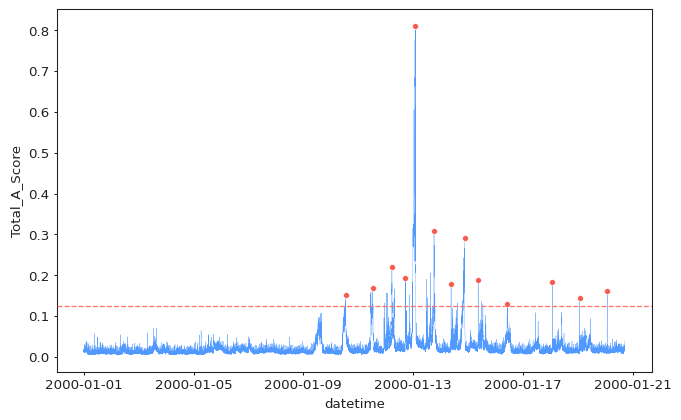

In [311]:
model.plot_extremes()

In [312]:
model.fit_model()
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                 Total_A_Score      Size:                              28,379
Start:                       January 2000      End:                         January 2000
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                 13      Extraction method:                    POT
Type:                                high      Threshold:             0.1252382006496191
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

(<Figure size 768x768 with 4 Axes>,
 (<AxesSubplot:title={'center':'Return value plot'}, xlabel='Return period', ylabel='Total_A_Score'>,
  <AxesSubplot:title={'center':'Probability density plot'}, xlabel='Total_A_Score', ylabel='Probability density'>,
  <AxesSubplot:title={'center':'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <AxesSubplot:title={'center':'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

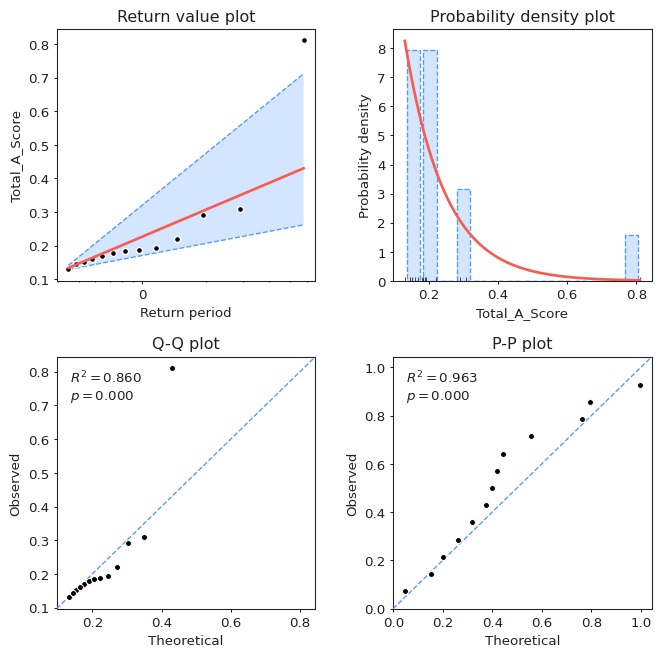

In [313]:
model.plot_diagnostic(alpha=0.95)

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='Threshold', ylabel='Mean excess'>)

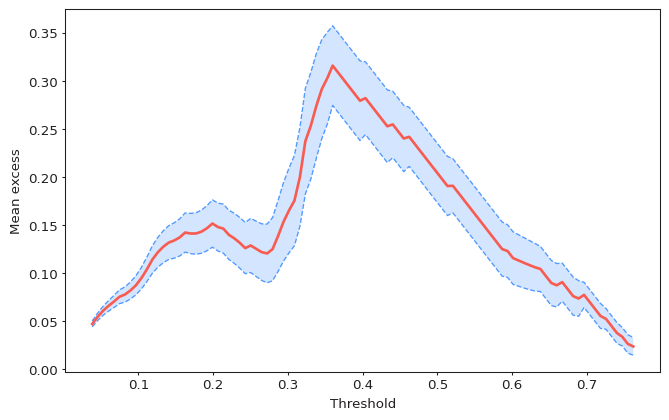

In [314]:
pyextremes.plot_mean_residual_life(ts=x_i)

(<Figure size 768x480 with 2 Axes>,
 (<AxesSubplot:ylabel='Shape, $\\xi$'>,
  <AxesSubplot:xlabel='Threshold', ylabel='Modified scale, $\\sigma^*$'>))

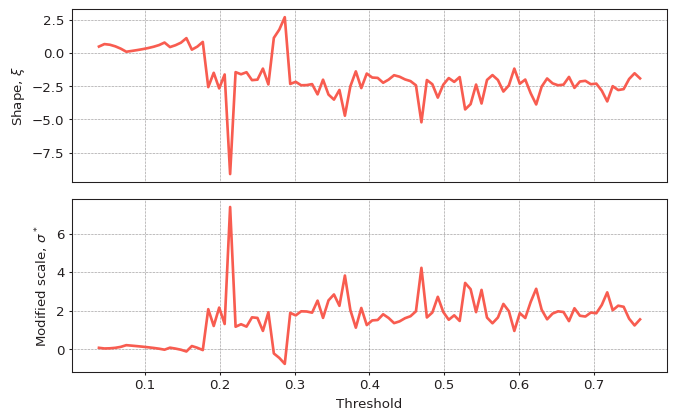

In [315]:
pyextremes.plot_parameter_stability(ts=x_i)

In [316]:
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages

base = importr('base')
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages('POT') #installing POT package

R[write to console]: trying URL 'https://cloud.r-project.org/bin/macosx/el-capitan/contrib/3.6/POT_1.1-7.tgz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 1399205 bytes (1.3 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


The downloaded binary packages are in
	/var/folders/r7/3_z3p06n3m79fcylhf7268r00000gn/T//Rtmp7NZXhN/downloaded_packages


<rpy2.rinterface_lib.sexp.NULLType object at 0x7ff00f15ae40> [RTYPES.NILSXP]

In [166]:
from thresholdmodeling import thresh_modeling

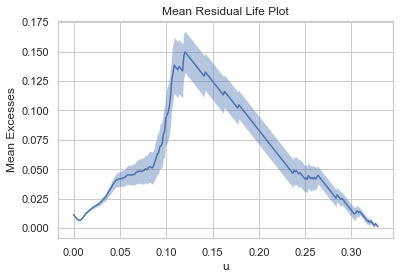

ValueError: Not an rpy2 R object and unable to map it into one: 0.0

In [169]:
thresh_modeling.MRL(x_i.values, 0.05)   
thresh_modeling.Parameter_Stability_plot(x_i.values, 0.05)

In [171]:
thresh_modeling.gpdfit(x_i, 0.04, 'mle')

Estimator: MLE 
 Deviance: -2543.882 
      AIC: -2539.882 

Varying Threshold: FALSE 

  Threshold Call: 0.04 
    Number Above: 508 
Proportion Above: 0.0179 

Estimates
  scale    shape  
0.01909  0.45584  

Standard Error Type: observed 

Standard Errors
  scale    shape  
0.00151  0.06896  

Asymptotic Variance Covariance
       scale       shape     
scale   2.279e-06  -6.547e-05
shape  -6.547e-05   4.756e-03

Optimization Information
  Convergence: successful 
  Function Evaluations: 57 
  Gradient Evaluations: 11 




(0.4558436534478324,
 0.019090373976198872,
 array([0.00160636, 0.00170884, 0.00197044, ..., 0.32482473, 0.32561872,
        0.32970429]),
 [2.472677934210743e-05,
  3.7888593894738753e-05,
  6.419630947367139e-05,
  0.00010020672773684153,
  0.00010082241686842214,
  0.00011718134331577951,
  0.00013397560552631804,
  0.00016177174321051896,
  0.00017515858042631283,
  0.00017558678850000675,
  0.0001766471776315781,
  0.00019129916131578606,
  0.0002593549749473692,
  0.0002620020995413169,
  0.0002710981916578953,
  0.0002899818942105198,
  0.0002921606539473681,
  0.0003451299717631487,
  0.00035081754531578885,
  0.0003881904854736856,
  0.00040949842368420697,
  0.0004114594148157749,
  0.00043838864976316477,
  0.0004475817552631531,
  0.00046056817998948313,
  0.0004917309547368479,
  0.0005094593870263245,
  0.0005777743211315758,
  0.0005935296499473761,
  0.0006578426466315804,
  0.0006911568138605328,
  0.0006920382877894787,
  0.0007022820673947341,
  0.0008309669692631652

Estimator: MLE 
 Deviance: -2543.882 
      AIC: -2539.882 

Varying Threshold: FALSE 

  Threshold Call: 0.04 
    Number Above: 508 
Proportion Above: 0.0179 

Estimates
  scale    shape  
0.01909  0.45584  

Standard Error Type: observed 

Standard Errors
  scale    shape  
0.00151  0.06896  

Asymptotic Variance Covariance
       scale       shape     
scale   2.279e-06  -6.547e-05
shape  -6.547e-05   4.756e-03

Optimization Information
  Convergence: successful 
  Function Evaluations: 57 
  Gradient Evaluations: 11 




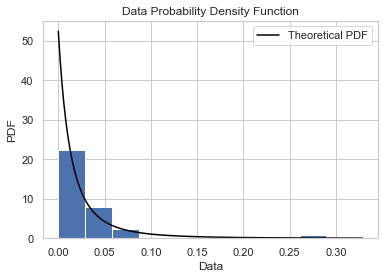

Estimator: MLE 
 Deviance: -2543.882 
      AIC: -2539.882 

Varying Threshold: FALSE 

  Threshold Call: 0.04 
    Number Above: 508 
Proportion Above: 0.0179 

Estimates
  scale    shape  
0.01909  0.45584  

Standard Error Type: observed 

Standard Errors
  scale    shape  
0.00151  0.06896  

Asymptotic Variance Covariance
       scale       shape     
scale   2.279e-06  -6.547e-05
shape  -6.547e-05   4.756e-03

Optimization Information
  Convergence: successful 
  Function Evaluations: 57 
  Gradient Evaluations: 11 




ValueError: x and y must have same first dimension, but have shapes (508,) and (505,)

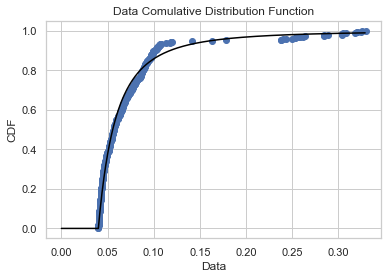

In [172]:
thresh_modeling.gpdpdf(x_i, 0.04, 'mle', 'sturges', 0.05)
thresh_modeling.gpdcdf(x_i, 0.04, 'mle', 0.05)
thresh_modeling.qqplot(x_i, 0.04, 'mle', 0.05)
thresh_modeling.ppplot(x_i, 0.04, 'mle', 0.05)